# Basic Hodgkin Huxley


INFO       Cache size for target 'cython': 1953 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\samaw\.cython\brian_extensions' directory. [brian2]


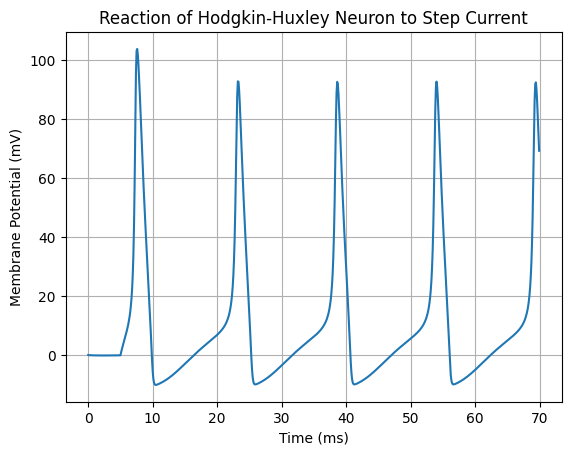

In [2]:
from brian2 import *
%matplotlib inline

start_scope()
simulation_time = 70 * ms
# Input current parameters
t_start = 5
t_end = 50
amplitude = 10 * uA

# Create the input current for the neuron
tmp_size = 1 + t_end
tmp = np.zeros((tmp_size, 1)) * amp
tmp[t_start: t_end + 1, 0] = amplitude
input_current = TimedArray(tmp, dt=1 * ms)

El = 10.6 * mV
EK = -12 * mV
ENa = 115 * mV
gl = 0.3 * msiemens
gK = 36 * msiemens
gNa = 120 * msiemens
C = 1 * ufarad

# forming HH model with differential equations
eqs = """
I_e = input_current(t,i) : amp
membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
    gl*(El-vm) + gK*n**4*(EK-vm) : amp
alphah = .07*exp(-.05*vm/mV)/ms    : Hz
alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
betam = 4*exp(-.0556*vm/mV)/ms : Hz
betan = .125*exp(-.0125*vm/mV)/ms : Hz
dh/dt = alphah*(1-h)-betah*h : 1
dm/dt = alpham*(1-m)-betam*m : 1
dn/dt = alphan*(1-n)-betan*n : 1
dvm/dt = membrane_Im/C : volt
"""

neuron = NeuronGroup(1, eqs, method="exponential_euler")

# parameter initialization
neuron.vm = 0
neuron.m = 0.05
neuron.h = 0.60
neuron.n = 0.32

# tracking parameters
st_mon = StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

# running the simulation
hh_net = Network(neuron)
hh_net.add(st_mon)
hh_net.run(simulation_time)



plot(st_mon.t / ms, st_mon.vm[0] / mV)
xlabel('Time (ms)')
ylabel('Membrane Potential (mV)')
title('Reaction of Hodgkin-Huxley Neuron to Step Current')
grid(True)



# Hodgkin Huxley with Calcium Channels

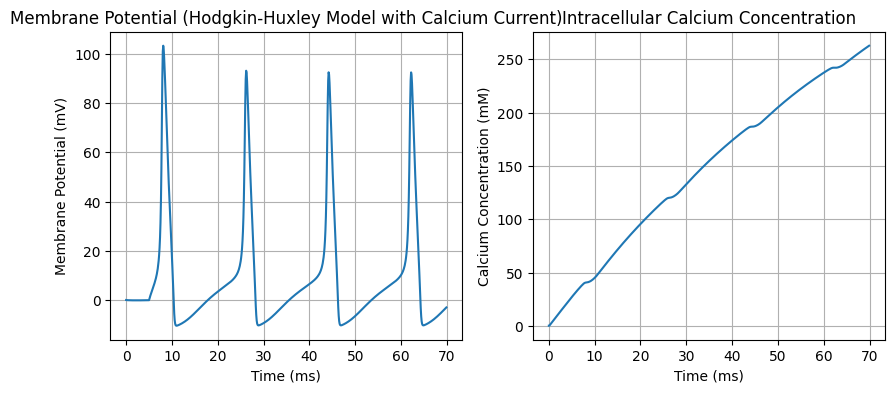

In [3]:
from brian2 import *
%matplotlib inline

start_scope()
simulation_time = 70 * ms
# Input current parameters
t_start = 5
t_end = 10
amplitude = 7 * uA

# Create the input current for the neuron
tmp_size = 1 + t_end
tmp = np.zeros((tmp_size, 1)) * amp
tmp[t_start: t_end + 1, 0] = amplitude
input_current = TimedArray(tmp, dt=1 * ms)

El = 10.6 * mV
EK = -12 * mV
ENa = 115 * mV
ECa = 120 * mV  
gl = 0.3 * msiemens
gK = 36 * msiemens
gNa = 120 * msiemens
gCa = 1e-4 * msiemens  
C = 1 * ufarad

eqs = """
I_e = input_current(t,i) : amp
membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
    gl*(El-vm) + gK*n**4*(EK-vm) + gCa*mCaL**2*hCa*(ECa-vm) : amp  # Calcium current added here
alphah = .07*exp(-.05*vm/mV)/ms    : Hz
alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
betam = 4*exp(-.0556*vm/mV)/ms : Hz
betan = .125*exp(-.0125*vm/mV)/ms : Hz
dh/dt = alphah*(1-h)-betah*h : 1
dm/dt = alpham*(1-m)-betam*m : 1
dn/dt = alphan*(1-n)-betan*n : 1

# Calcium channel dynamics (using vectorized operations)
alpha_Ca = 0.055 * (mV**-1) * (3.8 * mV) / (exp(-(vm + 27.*mV) / (3.8*mV))) / ms : Hz
beta_Ca = 0.94 * exp(-(vm + 75.*mV) / (17.*mV)) / ms : Hz
alpha_hCa = 0.000457 * exp(-(vm + 13.*mV) / (50.*mV)) / ms : Hz
beta_hCa = 0.0065 / (exp(-(vm + 15.*mV) / (28.*mV)) + 1.) / ms : Hz

# Calcium influx driving term
dmCaL/dt = (alpha_Ca * (1. - mCaL)) - (beta_Ca * mCaL) : 1
dhCa/dt = (alpha_hCa * (1. - hCa)) - (beta_hCa * hCa) : 1
dCa_i/dt = driveChannel + ((2.4e-4 * mole * metre**-3) - Ca_i) / (200.*ms) : mole*meter**-3

# Calcium influx driving term
driveChannel = (-(1e4) * gCa * mCaL**2 * hCa * (vm - ECa)) / (cm**2) / (2. * (96489*coulomb*mole**-1) * (1.*umetre)) : mole*meter**-3*Hz

dvm/dt = membrane_Im/C : volt
"""

neuron = NeuronGroup(1, eqs, method="exponential_euler")

neuron.vm = 0
neuron.m = 0.05
neuron.h = 0.60
neuron.n = 0.32
neuron.mCaL = 0.1  
neuron.hCa = 0.9  
neuron.Ca_i = 1e-4 * mole * metre**-3  

st_mon = StateMonitor(neuron, ["vm", "I_e", "m", "n", "h", "mCaL", "hCa", "Ca_i"], record=True)

hh_net = Network(neuron)
hh_net.add(st_mon)
hh_net.run(simulation_time)

figure(figsize=(10, 4))
subplot(121)
plot(st_mon.t / ms, st_mon.vm[0] / mV)
xlabel('Time (ms)')
ylabel('Membrane Potential (mV)')
title('Membrane Potential (Hodgkin-Huxley Model with Calcium Current)')
grid(True)

subplot(122)
plot(st_mon.t / ms, st_mon.Ca_i[0] * 1e3) 
xlabel('Time (ms)')
ylabel('Calcium Concentration (mM)')
title('Intracellular Calcium Concentration')
grid(True)

show()


# Hodgkin Huxley with Calcium Channels and CAN current dynamics

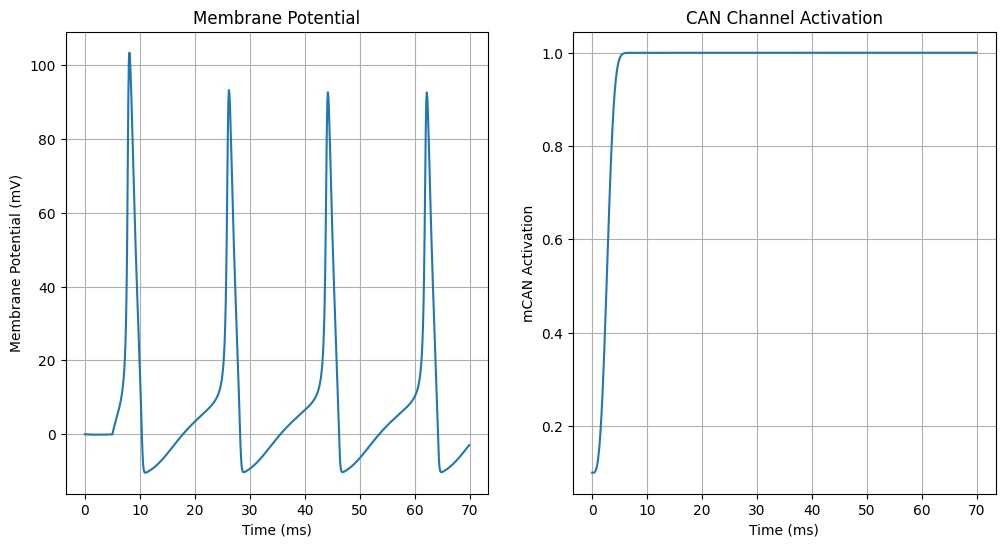

In [21]:
from brian2 import *
%matplotlib inline

start_scope()
simulation_time = 70 * ms

# Input current parameters
t_start = 5
t_end = 10
amplitude = 7 * uA

# Create the input current for the neuron
tmp_size = 1 + t_end
tmp = np.zeros((tmp_size, 1)) * amp
tmp[t_start: t_end + 1, 0] = amplitude
input_current = TimedArray(tmp, dt=1 * ms)

# Constants
El = 10.6 * mV
EK = -12 * mV
ENa = 115 * mV
ECa = 120 * mV  
gl = 0.3 * msiemens
gK = 36 * msiemens
gNa = 120 * msiemens
gCa = 1e-4 * msiemens  
gCAN = 1e-4 * msiemens  
C = 1 * ufarad

eqs = """
# External current
I_e = input_current(t,i) : amp

# Total membrane current
membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
    gl*(El-vm) + gK*n**4*(EK-vm) + \
    gCa*mCaL**2*hCa*(ECa-vm) + ICAN : amp 

# Sodium, Potassium, and Leak dynamics
alphah = .07*exp(-.05*vm/mV)/ms    : Hz
alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
betam = 4*exp(-.0556*vm/mV)/ms : Hz
betan = .125*exp(-.0125*vm/mV)/ms : Hz
dh/dt = alphah*(1-h)-betah*h : 1
dm/dt = alpham*(1-m)-betam*m : 1
dn/dt = alphan*(1-n)-betan*n : 1

# Calcium channel dynamics
alpha_Ca = 0.055 * (mV**-1) * (3.8 * mV) / (exp(-(vm + 27.*mV) / (3.8*mV))) / ms : Hz
beta_Ca = 0.94 * exp(-(vm + 75.*mV) / (17.*mV)) / ms : Hz
alpha_hCa = 0.000457 * exp(-(vm + 13.*mV) / (50.*mV)) / ms : Hz
beta_hCa = 0.0065 / (exp(-(vm + 15.*mV) / (28.*mV)) + 1.) / ms : Hz

dmCaL/dt = (alpha_Ca * (1. - mCaL)) - (beta_Ca * mCaL) : 1
dhCa/dt = (alpha_hCa * (1. - hCa)) - (beta_hCa * hCa) : 1
dCa_i/dt = driveChannel + ((2.4e-4 * mole * metre**-3) - Ca_i) / (200.*ms) : mole*meter**-3

driveChannel = (-(1e4) * gCa * mCaL**2 * hCa * (vm - ECa)) / (cm**2) / (2. * (96489*coulomb*mole**-1) * (1.*umetre)) : mole*meter**-3*Hz

# CAN current dynamics
ICAN = ((gCAN) * (1.)) * mCAN**2 * (vm + 20.*mV) : amp
dmCAN/dt = (mCANInf - mCAN) / mCANTau : 1
mCANInf = alpha2 / (alpha2 + (0.0002*ms**-1)) : 1
mCANTau = 1. / (alpha2 + (0.0002*ms**-1)) / (3.0**((36. - 22.) / 10.)) : second
alpha2 = (0.0002*ms**-1) * (Ca_i / (5e-4*mole*metre**-3))**2 : Hz

# Membrane potential
dvm/dt = membrane_Im / C : volt
"""

# Neuron setup
neuron = NeuronGroup(1, eqs, method="exponential_euler")
neuron.vm = 0
neuron.m = 0.05
neuron.h = 0.60
neuron.n = 0.32
neuron.mCaL = 0.1  
neuron.hCa = 0.9  
neuron.Ca_i = 1e-4 * mole * metre**-3  
neuron.mCAN = 0.1  

# Monitors
st_mon = StateMonitor(neuron, ["vm", "Ca_i", "mCAN"], record=True)

# Simulation
hh_net = Network(neuron)
hh_net.add(st_mon)
hh_net.run(simulation_time)

# Plot results
figure(figsize=(12, 6))
subplot(121)
plot(st_mon.t / ms, st_mon.vm[0] / mV)
xlabel('Time (ms)')
ylabel('Membrane Potential (mV)')
title('Membrane Potential')
grid(True)


subplot(122)
plot(st_mon.t / ms, st_mon.mCAN[0])
xlabel('Time (ms)')
ylabel('mCAN Activation')
title('CAN Channel Activation')
grid(True)

show()


# Hodgkin Huxley with Calcium Channels and CAN current dynamics and M current dynamics

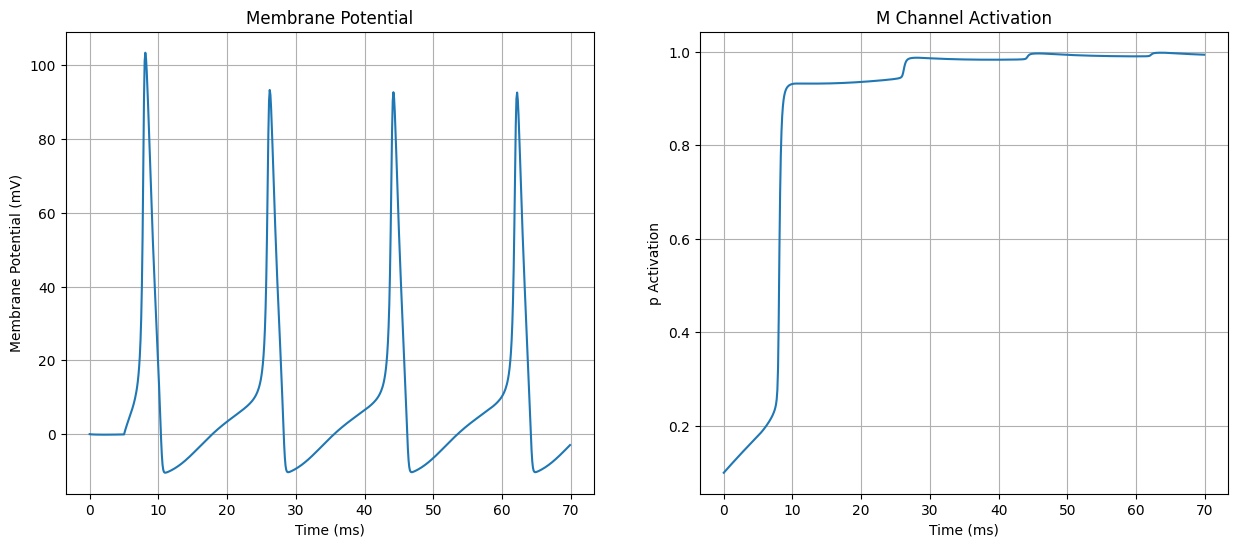

In [23]:
from brian2 import *
%matplotlib inline

start_scope()
simulation_time = 70 * ms

# Input current parameters
t_start = 5
t_end = 10
amplitude = 7 * uA

# Create the input current for the neuron
tmp_size = 1 + t_end
tmp = np.zeros((tmp_size, 1)) * amp
tmp[t_start: t_end + 1, 0] = amplitude
input_current = TimedArray(tmp, dt=1 * ms)

# Constants
El = 10.6 * mV
EK = -12 * mV
ENa = 115 * mV
ECa = 120 * mV  
gl = 0.3 * msiemens
gK = 36 * msiemens
gNa = 120 * msiemens
gCa = 1e-4 * msiemens  
gCAN = 1e-4 * msiemens  
gM = 1e-4 * msiemens  
C = 1 * ufarad

eqs = """
# External current
I_e = input_current(t,i) : amp

# Total membrane current
membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
    gl*(El-vm) + gK*n**4*(EK-vm) + \
    gCa*mCaL**2*hCa*(ECa-vm) + ICAN + IM : amp 

# Sodium, Potassium, and Leak dynamics
alphah = .07*exp(-.05*vm/mV)/ms    : Hz
alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
betam = 4*exp(-.0556*vm/mV)/ms : Hz
betan = .125*exp(-.0125*vm/mV)/ms : Hz
dh/dt = alphah*(1-h)-betah*h : 1
dm/dt = alpham*(1-m)-betam*m : 1
dn/dt = alphan*(1-n)-betan*n : 1

# Calcium channel dynamics
alpha_Ca = 0.055 * (mV**-1) * (3.8 * mV) / (exp(-(vm + 27.*mV) / (3.8*mV))) / ms : Hz
beta_Ca = 0.94 * exp(-(vm + 75.*mV) / (17.*mV)) / ms : Hz
alpha_hCa = 0.000457 * exp(-(vm + 13.*mV) / (50.*mV)) / ms : Hz
beta_hCa = 0.0065 / (exp(-(vm + 15.*mV) / (28.*mV)) + 1.) / ms : Hz

dmCaL/dt = (alpha_Ca * (1. - mCaL)) - (beta_Ca * mCaL) : 1
dhCa/dt = (alpha_hCa * (1. - hCa)) - (beta_hCa * hCa) : 1
dCa_i/dt = driveChannel + ((2.4e-4 * mole * metre**-3) - Ca_i) / (200.*ms) : mole*meter**-3

driveChannel = (-(1e4) * gCa * mCaL**2 * hCa * (vm - ECa)) / (cm**2) / (2. * (96489*coulomb*mole**-1) * (1.*umetre)) : mole*meter**-3*Hz

# CAN current dynamics
ICAN = ((gCAN) * (1.)) * mCAN**2 * (vm + 20.*mV) : amp
dmCAN/dt = (mCANInf - mCAN) / mCANTau : 1
mCANInf = alpha2 / (alpha2 + (0.0002*ms**-1)) : 1
mCANTau = 1. / (alpha2 + (0.0002*ms**-1)) / (3.0**((36. - 22.) / 10.)) : second
alpha2 = (0.0002*ms**-1) * (Ca_i / (5e-4*mole*metre**-3))**2 : Hz

# M current dynamics
IM = ((gM) * (1.)) * p * (vm - EK) : amp
dp/dt = (pInf - p) / pTau : 1
pInf = 1. / (1. + exp(- (vm + 35.*mV) / (10.*mV))) : 1
pTau = (1000.*ms) / (3.3 * exp((vm + 35.*mV) / (20.*mV)) + exp(- (vm + 35.*mV) / (20.*mV))) : second

# Membrane potential
dvm/dt = membrane_Im / C : volt
"""

# Neuron setup
neuron = NeuronGroup(1, eqs, method="exponential_euler")
neuron.vm = 0
neuron.m = 0.05
neuron.h = 0.60
neuron.n = 0.32
neuron.mCaL = 0.1  
neuron.hCa = 0.9  
neuron.Ca_i = 1e-4 * mole * metre**-3  
neuron.mCAN = 0.1  
neuron.p = 0.1  

# Monitors
st_mon = StateMonitor(neuron, ["vm", "Ca_i", "mCAN", "p"], record=True)

# Simulation
hh_net = Network(neuron)
hh_net.add(st_mon)
hh_net.run(simulation_time)

# Plot results
figure(figsize=(15, 6))
subplot(121)
plot(st_mon.t / ms, st_mon.vm[0] / mV)
xlabel('Time (ms)')
ylabel('Membrane Potential (mV)')
title('Membrane Potential')
grid(True)


subplot(122)
plot(st_mon.t / ms, st_mon.p[0])
xlabel('Time (ms)')
ylabel('p Activation')
title('M Channel Activation')
grid(True)

show()
